In [1]:
import os, glob

infected_dir = r"C:\Users\harse\Downloads\archive (4)\data\train\infected"
notinfected_dir = r"C:\Users\harse\Downloads\archive (4)\data\train\notinfected"

img_paths = sorted(glob.glob(os.path.join(infected_dir, "*")) + 
                   glob.glob(os.path.join(notinfected_dir, "*")))

print("Found images:", len(img_paths))
print("Example file:", img_paths[0])


Found images: 1924
Example file: C:\Users\harse\Downloads\archive (4)\data\train\infected\img1.jpg


In [2]:
# main diagnosis in pcos is presence of multiple cysts..manual observation
# takes times..ultrasound images can reveal cysts..making pipeline that analyses ultrasound images detects cyst
# like region extract texture and shape features ..

# what patterns make make infected images different..built image analysis pipeline to learn why
# how model can distinguish them..

# preprocess noisy medical images (CLAHE, grayscale, resizing)
# perform cyst detection with thresholding + contour filters
# extract interpretable features (area, count, texture)
# small preprocessing changes can affect medical image clarity and cyst detection accuracy

In [3]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

In [4]:
pip install scikit-image 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


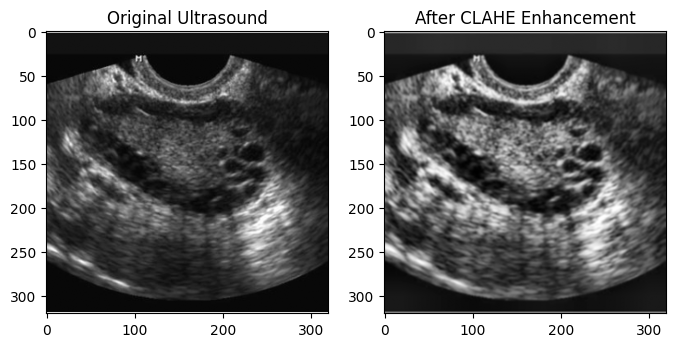

In [5]:
# we applies contrast limited adaptive histogram equalization (CLAHE)..preprocessing method for 
# medical images..
# reading ultrasound in grayscale becoz it is intensity based and not color based..
# each pixel between 0 and 255..ultrasound only have brightness and texture ..
# to enhance contrast of ultrasound images..enhances darker areas w/o over exposing bright ones..
# helps to make cysts more visible..

def preprocess_us(path, size=(320,320)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)   
    img = cv2.resize(img, size)                    
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    
    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)
    return img, enhanced

original, enhanced = preprocess_us(img_paths[0])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(original, cmap='gray'); plt.title("Original Ultrasound")
plt.subplot(1,2,2); plt.imshow(enhanced, cmap='gray'); plt.title("After CLAHE Enhancement")
plt.show()


In [6]:
# Thresholding is a basic image segmentation technique..
# helps separate objects (like cysts) from the background in a grayscale image..
# we have a grayscale ultrasound image..
# Bright gray = tissue
# Very dark = cyst
# Very bright = bone or noise
# apply a threshold value = 100..Pixels with value < 100 are cysts..
# Binary image = only black (0) and white (255) pixels..
# this simplifies further processing..

# Contours are boundaries (outlines) around the white regions in a binary image...
# After thresholding, OpenCV can detect these shapes automatically..

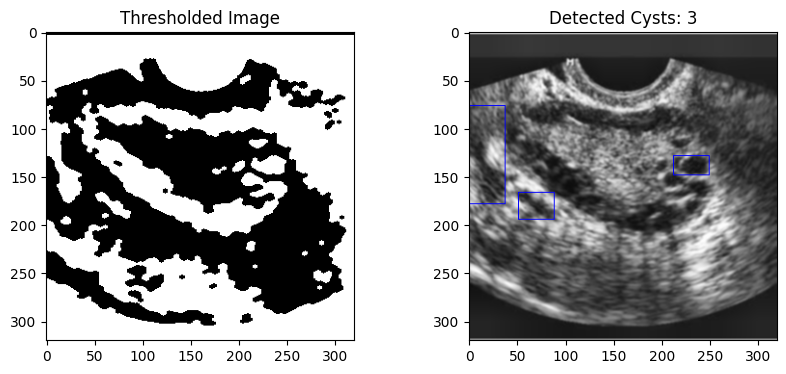

In [7]:
# thresholding converts image to black and white...dark regions(cysts) become the white spots..
# finding the contours..contour is the boundary of white region..each contour outlines one cyst..
# filter by area..small random spots(noise) are ignored..
# extremely large shaes are not real cysts either

def detect_cyst_candidates(enhanced_img, thresh_val=85, min_area=200, max_area=5000):
    _, th = cv2.threshold(enhanced_img, thresh_val, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]
    return candidates, th

# takes enhanced image(after CLAHE)..
# converts grayscale image to color image so we can draw rectangles around the cysts.
# OpenCV can only draw colors on 3-channel (color) images
# Made a color copy of my grayscale image so I can draw on it

cysts, binary = detect_cyst_candidates(enhanced)
overlay = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
for c in cysts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(overlay, (x,y),(x+w,y+h),(0,0,255), 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(binary, cmap='gray'); plt.title("Thresholded Image")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Detected Cysts: {len(cysts)}")
plt.show()

In [8]:
# this function converts the enhanced image into a black/white (binary) form
# detects contours (boundaries of round dark regions)
# filters them by size to remove noise
# output cysts is a list of all detected contours that might represent cysts

def extract_features(path):
    original, enhanced = preprocess_us(path)
    cysts, _ = detect_cyst_candidates(enhanced)

# quantitative analysis of images..
# cyst_count...more cysts is higher chance of PCOS...
# mean_cyst_area..larger cysts may show severity..
# total_cyst_area..measures how much of the ovary is affected
    cyst_areas = [cv2.contourArea(c) for c in cysts]
    cyst_count = len(cyst_areas)
    mean_cyst_area = np.mean(cyst_areas) if cyst_areas else 0
    total_cyst_area = np.sum(cyst_areas)
    img_area = original.shape[0] * original.shape[1]
    area_ratio = total_cyst_area / img_area  

# texture based features from image..
# GLCM (Gray Level Co-occurrence Matrix) - how often pairs of pixel brightness 
# values occur next to each other
# Contrast - variation or roughness there is in texture
# Homogeneity - measures how smooth the texture is

# calculates how smooth or rough the image texture is
# Texture tells you how the gray levels are distributed — important in medical images
# Output is contrast and homogeneity(texture indicators)

# PCOS-affected ovaries often have irregular textures because of many cysts
# infected images may show higher contrast values
# Normal ovaries are usually smoother (higher homogeneity) 
# PCOS ovaries tend to have multiple cysts..lower homogeneity..
    
    glcm = graycomatrix(enhanced, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    
    label = 1 if os.path.basename(os.path.dirname(path)) == "infected" else 0
    
    return {
        "img_id": os.path.basename(path),
        "label": label,
        "cyst_count": cyst_count,
        "mean_cyst_area": mean_cyst_area,
        "area_ratio": area_ratio,
        "contrast": contrast,
        "homogeneity": homogeneity
    }

features = extract_features(img_paths[0])
features

{'img_id': 'img1.jpg',
 'label': 1,
 'cyst_count': 3,
 'mean_cyst_area': np.float64(731.0),
 'area_ratio': np.float64(0.021416015625),
 'contrast': np.float64(73.54805054858936),
 'homogeneity': np.float64(0.3290987389338559)}

In [9]:
# the 0 and 1 labels come from the dataset and represent the real classification (normal vs PCOS)
# we use these labels during training so that the Random Forest can learn what patterns 
# in cyst count and texture correspond to each label

records = []
for path in img_paths:
    try:
        rec = extract_features(path)
        records.append(rec)
    except Exception as e:
        print("Error on:", path, e)

df = pd.DataFrame(records)
df.to_csv("pcos_ultrasound_features.csv", index=False)
df.head()

,img_id,label,cyst_count,mean_cyst_area,area_ratio,contrast,homogeneity
0,img1.jpg,1,3,731.000000,0.021416,73.548051,0.329099
1,img10.jpg,1,19,1348.184211,0.250151,189.884826,0.176474
2,img2.jpg,1,14,873.642857,0.119443,124.454203,0.288132
3,img3.jpg,1,19,1262.973684,0.234341,192.949510,0.179468
4,img4.jpg,1,13,927.653846,0.117769,124.311080,0.279589


In [10]:
df['label'].value_counts()

label
0    1143
1     781
Name: count, dtype: int64

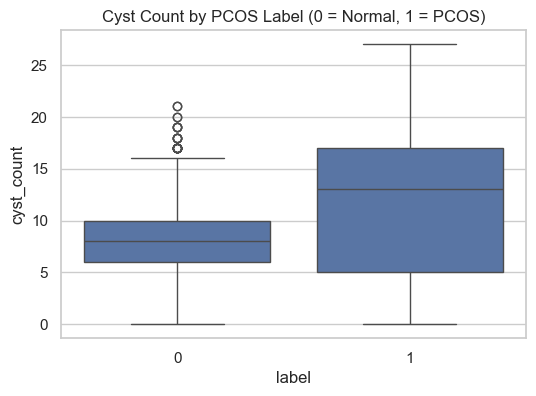

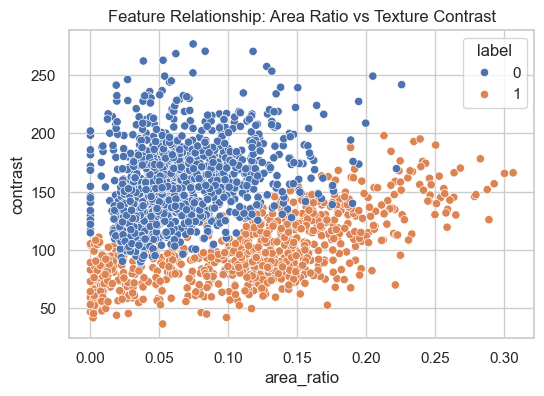

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='cyst_count', data=df)
plt.title("Cyst Count by PCOS Label (0 = Normal, 1 = PCOS)")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='area_ratio', y='contrast', hue='label', data=df)
plt.title("Feature Relationship: Area Ratio vs Texture Contrast")
plt.show()

In [12]:
# (boxplot) 
# x-axis has two categories 0 (Not Infected) and 1 (PCOS / Infected)
# y-axis has number of cysts detected in each image
# box for label 1 (PCOS) higher than label 0 (Normal) 
# PCOS images generally have more cysts detected than normal images
# Normal ovaries contain few or no cysts
# boxplot visually proves that feature extraction step (cyst detection) worked correctly
# height of box shows variation or interquartile range..PCOS ovaries not only have
# more cysts on average but also greater variation in cyst count across patients
# It helps us check that the features we extracted like cyst count are actually 
# differentiating between the two classes

In [13]:
# scatterplot
# Each dot on scatter plot represents one ultrasound image from your dataset
# PCOS (label 1) points lie toward higher area_ratio (more cyst coverage)
# Normal (label 0) points stay closer to lower area_ratio and 
# lower contrast (smoother texture, fewer cysts)
# Area Ratio measures how much of the ovary is covered by cysts
# PCOS ovaries typically have many cysts, so a higher area ratio
# Normal ovaries have smaller or fewer cysts so lower area ratio
# Contrast is derived from the GLCM texture matrix

In [14]:
# machine learning model(Random Forest) is learning from real, separable data not random noise

In [15]:
# X has all the image-based features extracted for every image (numerc data not pixels)
# y has the labels (0 for normal, 1 for infected)
# each row in df represent one image
# after extracting features for all images, 
# we combined both infected and non-infected samples into one DataFrame
# we are giving numerical summary of each image to Random Forest
# Random forest does not see image
# it only sees number like cyst_count = 5, mean_cyst_area = 1.3, etc..
# It tries to learn.. when cyst_count is high and texture is rough..likely PCOS
# when cyst_count is low and texture is smooth..likely normal
# learning decision rules based on the extracted information

In [16]:
# not directly using raw ultrasound images in the model
# process each image to extract measurable features — like cyst count, cyst area
# and texture values
# These numeric features form a dataset that we feed into the Random Forest

In [17]:
# Random Forest cannot directly process raw image pixels
# images are large and noisy..we simplify them into meaningful numeric features
# makes the system more interpretable we can say “Model predicts PCOS because 
# cyst_count = 8 and contrast is high

In [18]:
X = df[["cyst_count","mean_cyst_area","area_ratio","contrast","homogeneity"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, 
                                                    shuffle=True
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       283
           1       0.98      0.96      0.97       198

    accuracy                           0.98       481
   macro avg       0.98      0.97      0.98       481
weighted avg       0.98      0.98      0.98       481



In [19]:
# running detection on multiple images automatically..saving the visuals..
# saves overlay images in a separate folder
# used to generate final results for report or future model evaluation
# proof of cyst detection results..
# These overlays are used in presentations or reports as qualitative proof that
# computer vision approach actually works...

save_dir = "outputs/overlays"
os.makedirs(save_dir, exist_ok=True)

for p in img_paths[:10]:   
    orig, enh = preprocess_us(p)
    cysts, _ = detect_cyst_candidates(enh)
    overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    for c in cysts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(overlay, (x,y),(x+w,y+h),(0,0,255),1)
    fname = os.path.basename(p)
    cv2.imwrite(os.path.join(save_dir, fname+"_overlay.jpg"), overlay)


In [20]:
# file path where overlaya is stored..
import os
print(os.getcwd())

C:\Users\harse


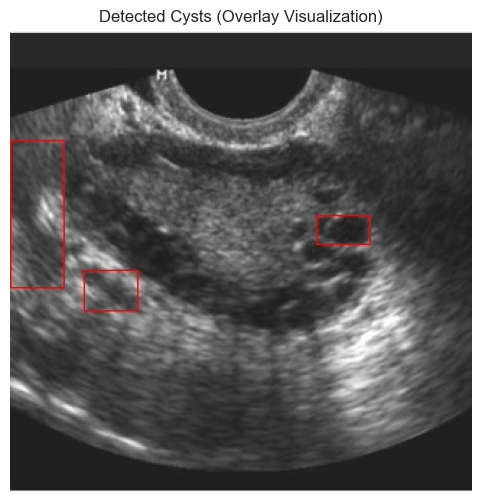

In [21]:
import cv2
import matplotlib.pyplot as plt
import os

save_dir = "outputs/overlays"

overlay_images = [f for f in os.listdir(save_dir) if f.endswith(".jpg")]
sample_overlay = os.path.join(save_dir, overlay_images[0])  

img = cv2.imread(sample_overlay)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title("Detected Cysts (Overlay Visualization)")
plt.show()

In [22]:
infected_dir = r"C:\Users\harse\Downloads\archive (4)\data\train\infected"

In [23]:
import glob, os

img_list = glob.glob(infected_dir + "/*.jpg") + \
           glob.glob(infected_dir + "/*.jpg") + \
           glob.glob(infected_dir + "/*.jpg")

print("Found images:", len(img_list))
print("First few files:", img_list[:10])

Found images: 2343
First few files: ['C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img1.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img10.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img2.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img3.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img4.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img5.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img6.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img7.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img8.jpg', 'C:\\Users\\harse\\Downloads\\archive (4)\\data\\train\\infected\\img_0_1023.jpg']


Sample image: C:\Users\harse\Downloads\archive (4)\data\train\infected\img_0_6498.jpg


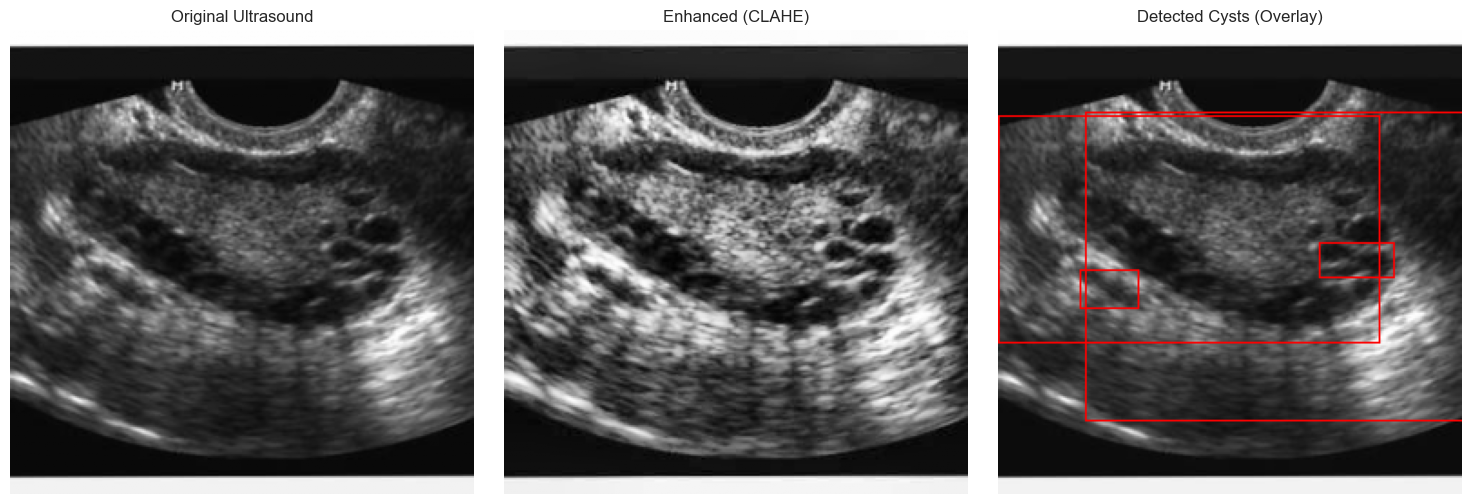

In [24]:
# entire computer vision pipeline on a single image..
import cv2
import matplotlib.pyplot as plt
import random

sample_path = random.choice(img_list)
print("Sample image:", sample_path)

# Preprocessing
def preprocess_us(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    return img, enhanced

# Cyst Detection 
def detect_cyst_candidates(enhanced, thresh_val=75, min_area=100, max_area=8000):
    _, thresh = cv2.threshold(enhanced, thresh_val, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cysts = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    return cysts

# Process the image
orig, enhanced = preprocess_us(sample_path)
cysts = detect_cyst_candidates(enhanced)

overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
for c in cysts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 0, 255), 1)

overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display Results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig, cmap='gray')
plt.title("Original Ultrasound")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(enhanced, cmap='gray')
plt.title("Enhanced (CLAHE)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay_rgb)
plt.title("Detected Cysts (Overlay)")
plt.axis('off')

plt.tight_layout()
plt.show()


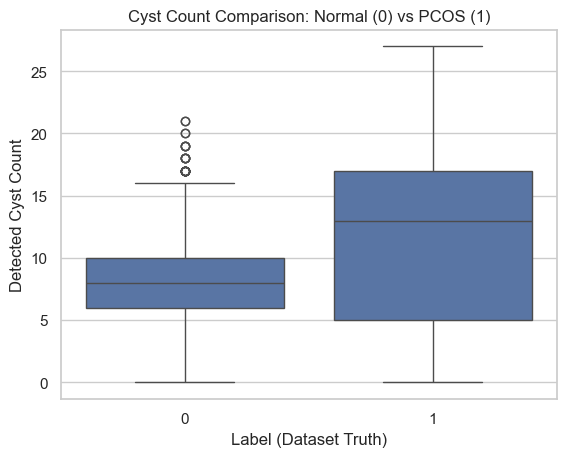

label
0     8.378828
1    11.599232
Name: cyst_count, dtype: float64


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare cyst count for normal vs infected
sns.boxplot(x='label', y='cyst_count', data=df)
plt.title("Cyst Count Comparison: Normal (0) vs PCOS (1)")
plt.xlabel("Label (Dataset Truth)")
plt.ylabel("Detected Cyst Count")
plt.show()

# Also print mean cyst count for both classes
print(df.groupby("label")["cyst_count"].mean())


In [37]:
def calculate_shape_features(cysts):

# Create empty lists to store shape measurements of each detected cyst
    areas = []
    widths = []
    heights = []
    roundness = []

    for c in cysts:

        # area of the cyst
        area = cv2.contourArea(c)

        # width and height of cyst
        # boundingRect gives (x, y, width, height) of a rectangle covering the cyst
        x, y, w, h = cv2.boundingRect(c)

        # Store values
        areas.append(area)
        widths.append(w)
        heights.append(h)
        
        # roundness of the cyst
        # roundness = 4πA / P²
        # A = area, P = perimeter
        # Higher value - more circular shape
        
        perimeter = cv2.arcLength(c, True)
        if perimeter != 0:
            r = (4 * np.pi * area) / (perimeter ** 2)
        else:
            r = 0
        roundness.append(r)
        
    # return the average shape measurements of all cysts in that image
    return {
        "mean_area": np.mean(areas) if areas else 0,
        "mean_width": np.mean(widths) if widths else 0,
        "mean_height": np.mean(heights) if heights else 0,
        "mean_roundness": np.mean(roundness) if roundness else 0,
        "count": len(cysts)
    }


In [38]:
records = []

# Load image and enhance it using CLAHE (improves contrast)
for path in img_paths:
    orig, enhanced = preprocess_us(path)

# Detect cyst-like circular dark areas in the enhanced image
    result = detect_cyst_candidates(enhanced)
    if isinstance(result, tuple):
        cysts, binary = result
    else:
        cysts = result
        binary = None

    shape_feats = calculate_shape_features(cysts)

    
    folder = os.path.basename(os.path.dirname(path)).lower()
    if folder == "infected":
        label = 1
    else:
        label = 0

# Store all results in a list of dictionaries
    records.append({
        "image": os.path.basename(path),
        "label": label,
        "cyst_count": shape_feats["count"],
        "mean_area": shape_feats["mean_area"],
        "mean_width": shape_feats["mean_width"],
        "mean_height": shape_feats["mean_height"],
        "mean_roundness": shape_feats["mean_roundness"]
    })

df_shapes = pd.DataFrame(records)
df_shapes.head()

,image,label,cyst_count,mean_area,mean_width,mean_height,mean_roundness
0,img1.jpg,1,5,953.800000,58.800000,50.800000,0.263368
1,img10.jpg,1,24,934.583333,49.416667,40.541667,0.197838
2,img2.jpg,1,19,449.342105,35.842105,29.000000,0.361674
3,img3.jpg,1,22,1056.909091,55.272727,42.363636,0.184484
4,img4.jpg,1,17,489.205882,37.647059,29.647059,0.382522


C:\Users\harse\AppData\Local\Temp\ipykernel_21452\2240449745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_shapes, x="label", y="cyst_count", palette="viridis")


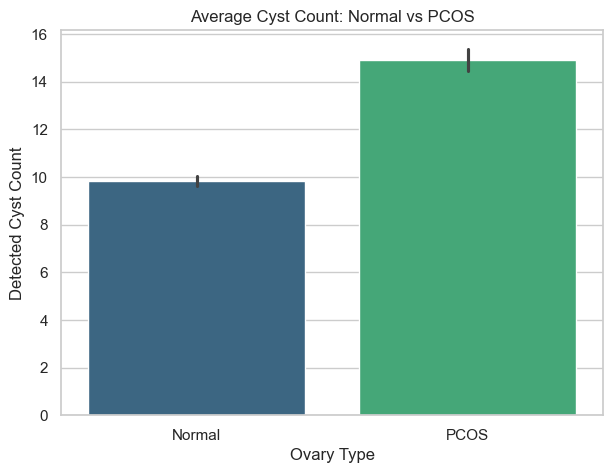

In [39]:
plt.figure(figsize=(7,5))
sns.barplot(data=df_shapes, x="label", y="cyst_count", palette="viridis")
plt.xticks([0,1], ["Normal", "PCOS"])
plt.title("Average Cyst Count: Normal vs PCOS")
plt.ylabel("Detected Cyst Count")
plt.xlabel("Ovary Type")
plt.show()
